In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

2024-08-16 04:03:50.845724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 04:03:50.845882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 04:03:51.011719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**For Image**

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [3]:
model = InceptionV3(weights='imagenet', include_top=False)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
import tensorflow as tf

def load_image(img_path):
    
    # Read the image from file
    img = tf.io.read_file(img_path)
    
    # Decode the image as a JPEG file
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize the image to the target size for Inception v3 (299x299)
    img = tf.image.resize(img, [299, 299])
    
    # Normalize the image to the range [0, 1]
    img = img / 255.0
    
    # Add a batch dimension (1, 299, 299, 3)
    img = tf.expand_dims(img, axis=0)
    
    return img



In [5]:
def get_feature_vector(img_path):
    
    # Load and preprocess the image
    img = load_image(img_path)
    
    # Load the Inception v3 model without the top layer
    model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
    
    # Pass the image through the model to get the feature vector
    feature_vector = model.predict(img)
    
    return img, feature_vector


In [6]:
def show_image_and_feature_vector(img_path):
    
    # Get the preprocessed image and feature vector
    img, feature_vector = get_feature_vector(img_path)
    
    # Remove the batch dimension for displaying the image
    img_for_display = tf.squeeze(img, axis=0)
    
    # Plot the image
    plt.imshow(img_for_display)
    plt.axis('off')  # Hide axis
    plt.title('Preprocessed Image')
    plt.show()
    
    # Print the dimensions of the feature vector
    print("Feature vector shape:", feature_vector.shape)

In [ ]:
img_path = '/kaggle/input/bangla-image-captioning-datasetmodified/BanglaImageCaptioning/BanCap/1000268201_693b08cb0e.jpg'
show_image_and_feature_vector(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


**For text**

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [ ]:
import pandas as pd
import re

# Read the captions file into a DataFrame
captions = pd.read_csv('/kaggle/input/bancap/BAN-Cap_captiondata.csv')

# Define the preprocessing function
def preprocess(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

# Apply the preprocessing function to the 'caption' column
captions['english_caption'] = captions['english_caption'].apply(preprocess)

# Print the first few rows to verify the changes
print(captions.head())


                    caption_id  \
0  1000268201_693b08cb0e.jpg#0   
1  1000268201_693b08cb0e.jpg#1   
2  1000268201_693b08cb0e.jpg#2   
3  1000268201_693b08cb0e.jpg#3   
4  1000268201_693b08cb0e.jpg#4   

                                     english_caption  \
0  [start] a child in a pink dress is climbing up...   
1  [start] a girl going into a wooden building [end]   
2  [start] a little girl climbing into a wooden p...   
3  [start] a little girl climbing the stairs to h...   
4  [start] a little girl in a pink dress going in...   

                                     bengali_caption  
0  একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1             একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2               একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3           ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4  গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...  


In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,  # No standardization if already preprocessed
    output_sequence_length=MAX_LENGTH)

# Adapt the tokenizer to the captions data
tokenizer.adapt(captions['english_caption'].values)

# Example usage of the tokenizer
sample_caption = "A sample caption to tokenize"
tokenized_caption = tokenizer([sample_caption])
print("Tokenized caption:", tokenized_caption)

Tokenized caption: tf.Tensor(
[[ 1  1  1 21  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 40), dtype=int64)


In [ ]:
import tensorflow as tf
import pandas as pd
import re

# Constants for tokenizer configuration
VOCABULARY_SIZE = 1000  # Adjust according to your vocabulary size requirement
MAX_LENGTH = 20  # Adjust according to your maximum sequence length requirement



# Apply the preprocessing function to the 'english_caption' column
captions['english_caption'] = captions['english_caption'].apply(preprocess)

# Initialize the TextVectorization layer
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,  # No standardization if already preprocessed
    output_sequence_length=MAX_LENGTH)

# Adapt the tokenizer to the captions data
tokenizer.adapt(captions['english_caption'].values)

# Initialize StringLookup for word to index mapping
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

# Initialize StringLookup for index to word mapping
idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

# Example usage of word to index and index to word lookup
sample_caption = "A sample caption to tokenize"
tokenized_caption = tokenizer([sample_caption])
# Ensure tokenized_caption is a list of strings
tokenized_caption = tf.squeeze(tokenized_caption).numpy().astype(str).tolist()
idx_caption = word2idx(tokenized_caption)
decoded_caption = idx2word(idx_caption)
print("Tokenized caption:", tokenized_caption)
print("Indexed caption:", idx_caption)
print("Decoded caption:", decoded_caption)


Tokenized caption: ['1', '1', '1', '23', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Indexed caption: tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int64)
Decoded caption: tf.Tensor(
[b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
 b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
 b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'], shape=(20,), dtype=string)


In [ ]:
# Assuming you've already initialized tokenizer, word2idx, and idx2word as shown previously
sample_caption = "A sample caption to tokenize"

# Tokenize the sample caption
tokenized_caption = tokenizer([sample_caption])
print("Tokenized caption:", tokenized_caption)

# Convert tokenized caption to list of strings
tokenized_caption = tf.squeeze(tokenized_caption).numpy().astype(str).tolist()

# Map tokens to indices
idx_caption = word2idx(tokenized_caption)
print("Indexed caption:", idx_caption)

# Decode indices back to words
decoded_caption = idx2word(idx_caption)
print("Decoded caption:", decoded_caption)


Tokenized caption: tf.Tensor([[ 1  1  1 23  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 20), dtype=int64)
Indexed caption: tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int64)
Decoded caption: tf.Tensor(
[b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
 b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
 b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'], shape=(20,), dtype=string)


**Another Approach**

In [14]:
import os
import time
import shutil
import pathlib
import itertools
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
import cv2
import matplotlib.patches as patches
import random
from tensorflow.keras.utils import Sequence
from IPython.display import Image
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu
import gc
import requests
from io import BytesIO

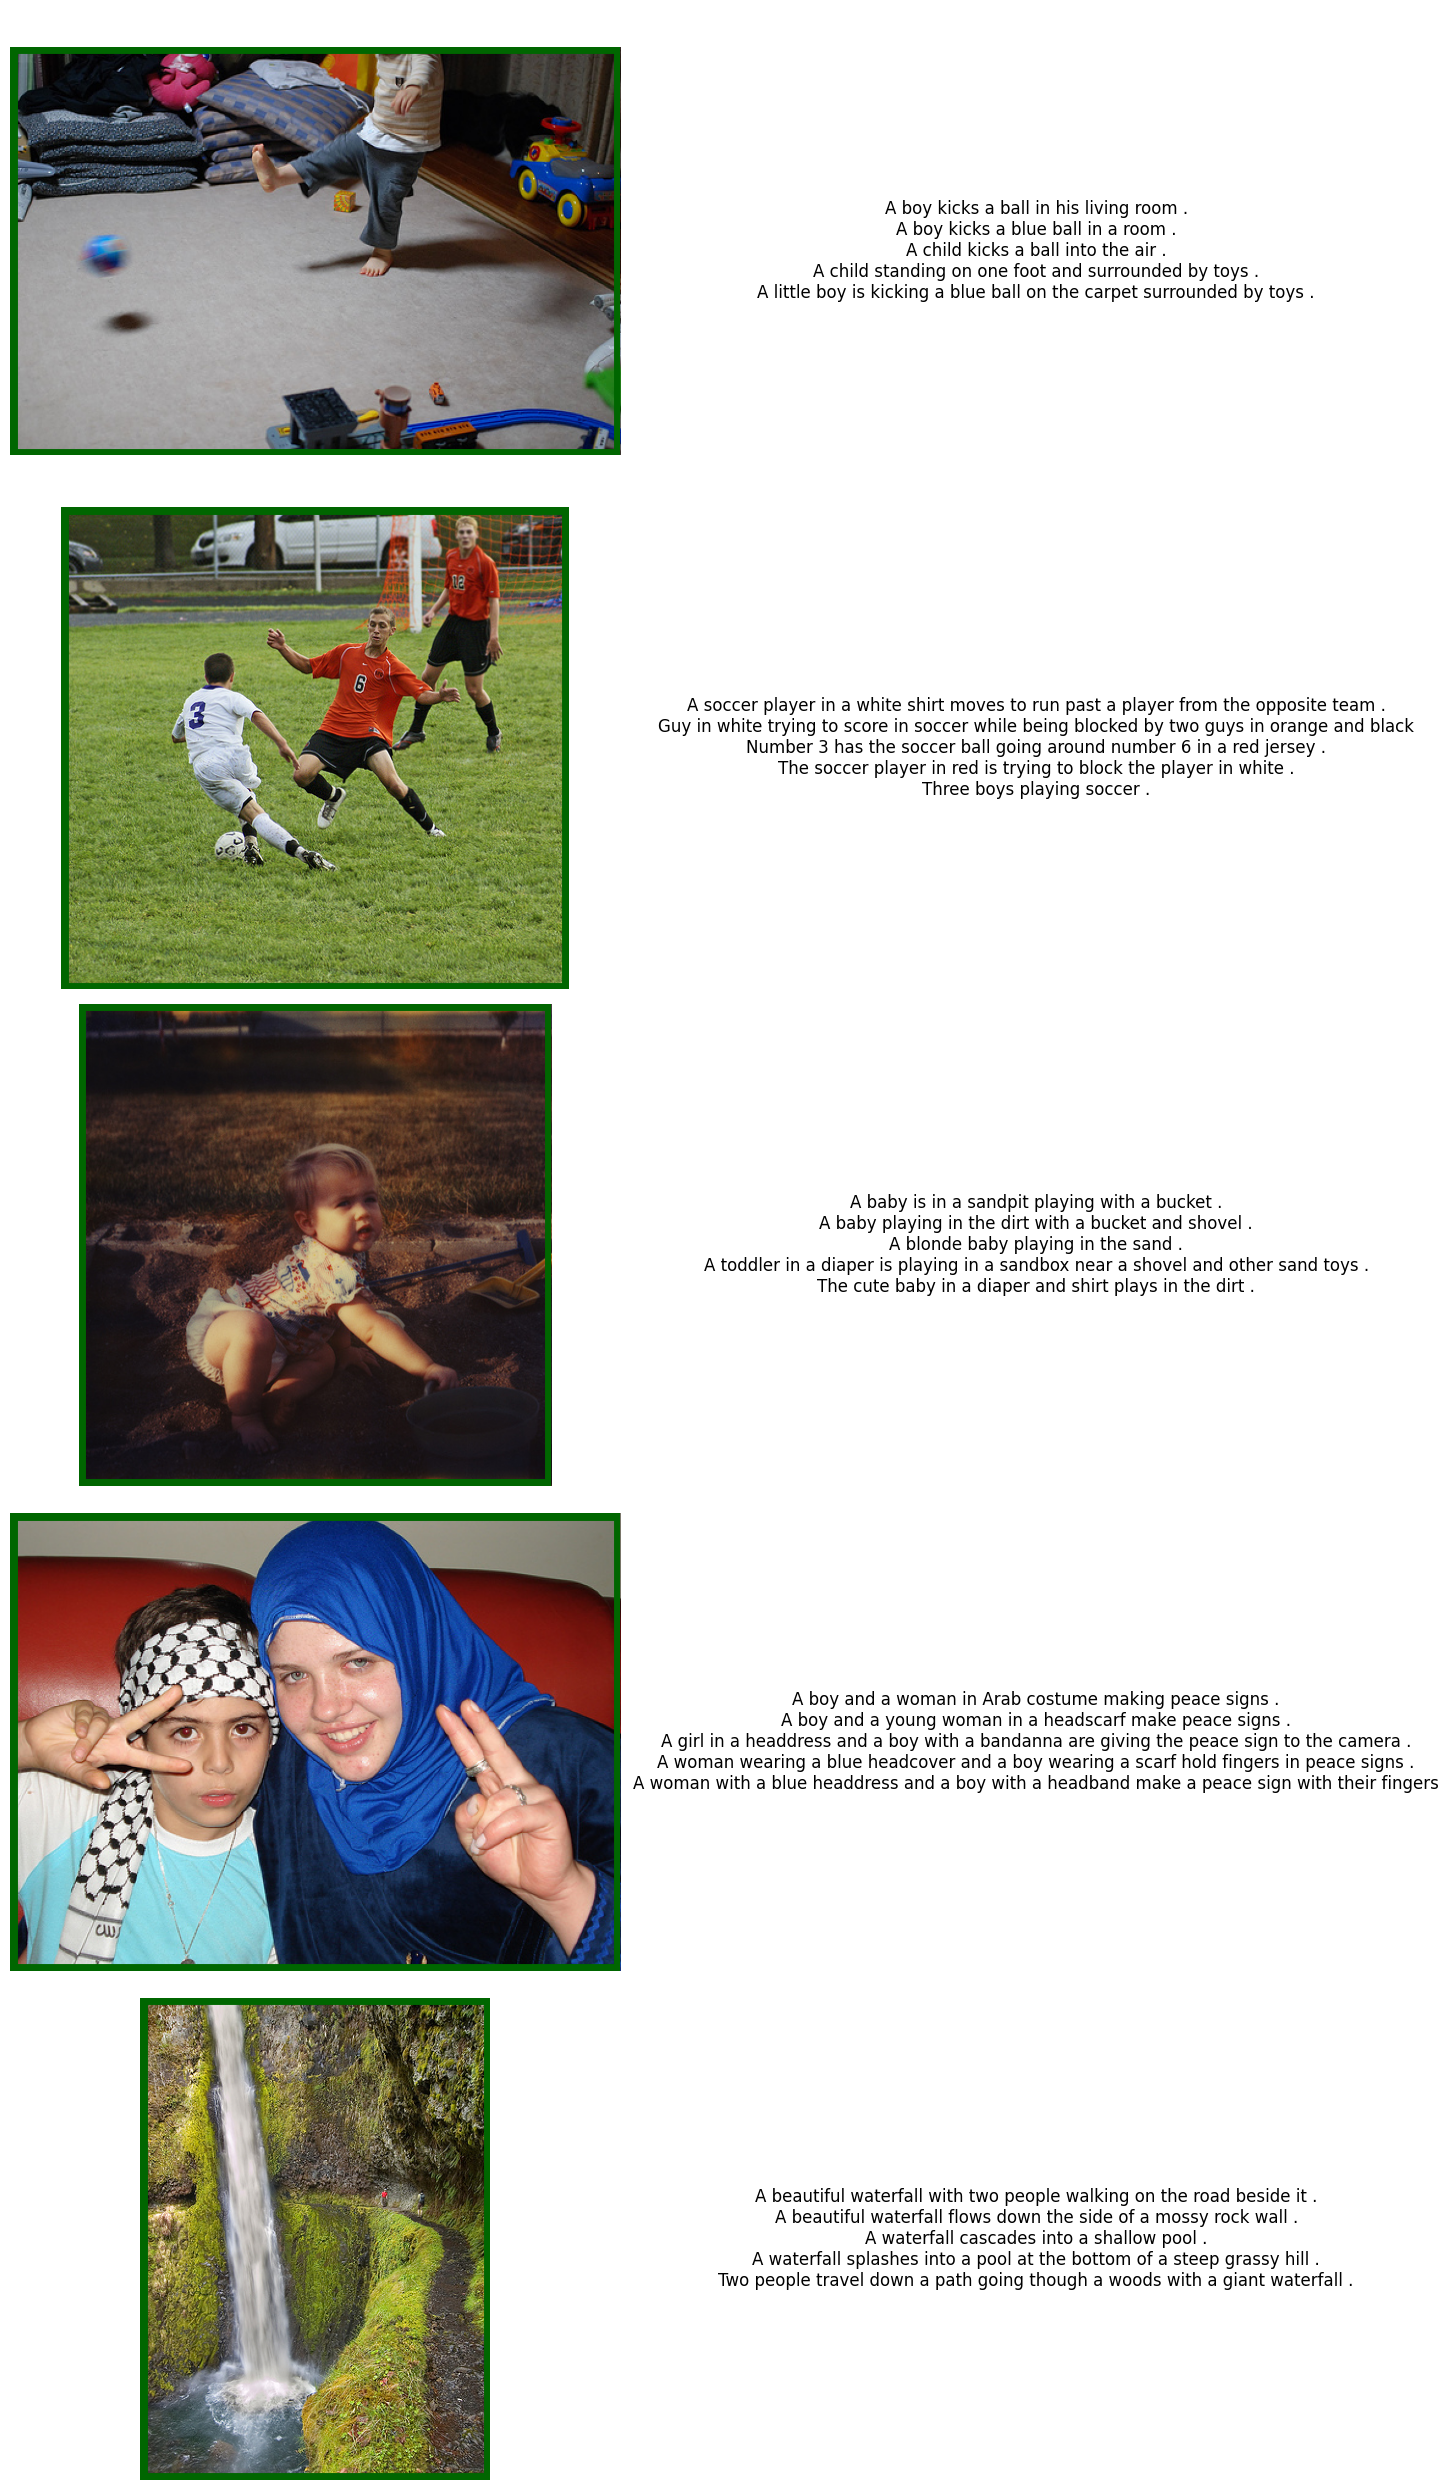

In [15]:
import cv2
import matplotlib.patches as patches
with open('/kaggle/input/flickr8k/captions.txt', 'r') as file:
    lines = file.readlines()

captions_dict = {}
for line in lines:
    image_name, caption = line.strip().split(',', 1)
    if image_name not in captions_dict:
        
        captions_dict[image_name] = []
    captions_dict[image_name].append(caption)

# 5 random images
selected_images = random.sample(list(captions_dict.keys()), 5)

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for idx, image_name in enumerate(selected_images):
   
    image_path = f'/kaggle/input/flickr8k/Images/{image_name}'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    axes[idx, 0].imshow(image)
    axes[idx, 0].axis('off')
    
    
    
    rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, edgecolor='#006600', facecolor='none')
    axes[idx, 0].add_patch(rect)
    
    
    captions = captions_dict[image_name]
    captions_text = "\n".join(captions)
    axes[idx, 1].text(0.5, 0.5, captions_text, ha='center', va='center', wrap=True, fontsize=12)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()


In [16]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'


data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [17]:
base_model = InceptionV3(weights='imagenet', include_top=False) 

In [18]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from tensorflow.keras.models import Model
x = base_model.output # since xception does not have any fully connected layers 
x = GlobalAveragePooling2D()(x) # added a avg pooling layer
model = Model(inputs=base_model.input, outputs=x)

In [19]:
#model.summary()

In [ ]:
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
#Load features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
#Load Captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

In [ ]:
#function to clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [ ]:
# Word2vector for vector embeddings of the text
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [ ]:
# Word2vector for vector embeddings of the text
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [ ]:
# Create embedding matrix
embedding_dim = 512
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [ ]:
max_length = max(len(caption) for caption in all_captions)
max_length

In [ ]:
# Train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Data generator function
def data_generator(data_keys, mapping, features, word_index, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = [word_index[word] for word in caption.split() if word in word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# Model architecture
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
# model.summary()

In [ ]:
# Train the model
epochs = 42  #epochs > 64 causing memory error
batch_size = 16
steps = len(train) // batch_size
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
for i in range(epochs):
    generator = data_generator(train, mapping, features, word_index, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])

In [ ]:
# Prediction functions
def idx_to_word(integer, word_index):
    for word, index in word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, word_index, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[word] for word in in_text.split() if word in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, word_index)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], word_index, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
model.save(WORKING_DIR + '/model.keras')

In [ ]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption('1012212859_01547e3f17.jpg')